In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from scipy.special import factorial

import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)


## Erlang-C Implementation

Queuing theory model to calculate call center metrics.


In [2]:
def erlang_c(num_agents, traffic):
    if num_agents <= 0 or traffic <= 0:
        return 0.0
    
    if traffic >= num_agents:
        return 1.0
    
    n = int(num_agents)
    a = traffic
    
    erlang_b_numerator = (a ** n) / factorial(n)
    erlang_b_denominator = sum([(a ** k) / factorial(k) for k in range(n)])
    erlang_b_denominator += erlang_b_numerator * (n / (n - a))
    
    probability_wait = erlang_b_numerator * (n / (n - a)) / erlang_b_denominator
    
    return probability_wait


def calculate_asa(num_agents, traffic, aht_seconds):
    prob_wait = erlang_c(num_agents, traffic)
    
    if num_agents <= traffic:
        return float('inf')
    
    asa = (prob_wait * aht_seconds) / (num_agents - traffic)
    return asa


def calculate_occupancy(num_agents, traffic):
    if num_agents <= 0:
        return 1.0
    return traffic / num_agents


def calculate_service_level(num_agents, traffic, aht_seconds, target_seconds=20):
    prob_wait = erlang_c(num_agents, traffic)
    
    if num_agents <= traffic:
        return 0.0
    
    service_level = 1 - prob_wait * np.exp(-(num_agents - traffic) * target_seconds / aht_seconds)
    return service_level


print("Erlang-C functions ready")


Erlang-C functions ready


## Testing


In [3]:
test_scenarios = [
    {"agents": 20, "calls_per_hour": 100, "aht_seconds": 180},
    {"agents": 30, "calls_per_hour": 200, "aht_seconds": 180},
    {"agents": 50, "calls_per_hour": 500, "aht_seconds": 180}
]

for i, scenario in enumerate(test_scenarios, 1):
    agents = scenario["agents"]
    calls_per_hour = scenario["calls_per_hour"]
    aht_seconds = scenario["aht_seconds"]
    
    traffic = (calls_per_hour / 3600) * aht_seconds
    
    pw = erlang_c(agents, traffic)
    asa = calculate_asa(agents, traffic, aht_seconds)
    occ = calculate_occupancy(agents, traffic)
    sl = calculate_service_level(agents, traffic, aht_seconds)
    
    print(f"Scenario {i}: {agents} agents, {calls_per_hour} calls/hr, {aht_seconds}s AHT")
    print(f"  Traffic: {traffic:.2f} | P(wait): {pw:.2%} | ASA: {asa:.1f}s | Occ: {occ:.1%} | SL: {sl:.1%}\n")


Scenario 1: 20 agents, 100 calls/hr, 180s AHT
  Traffic: 5.00 | P(wait): 0.00% | ASA: 0.0s | Occ: 25.0% | SL: 100.0%

Scenario 2: 30 agents, 200 calls/hr, 180s AHT
  Traffic: 10.00 | P(wait): 0.00% | ASA: 0.0s | Occ: 33.3% | SL: 100.0%

Scenario 3: 50 agents, 500 calls/hr, 180s AHT
  Traffic: 25.00 | P(wait): 0.00% | ASA: 0.0s | Occ: 50.0% | SL: 100.0%



Test scenarios show Erlang-C functions working correctly. When agents significantly exceed traffic (traffic/agents < 0.5), nearly all calls are answered immediately with 100% service level and low occupancy.

## Visualizations


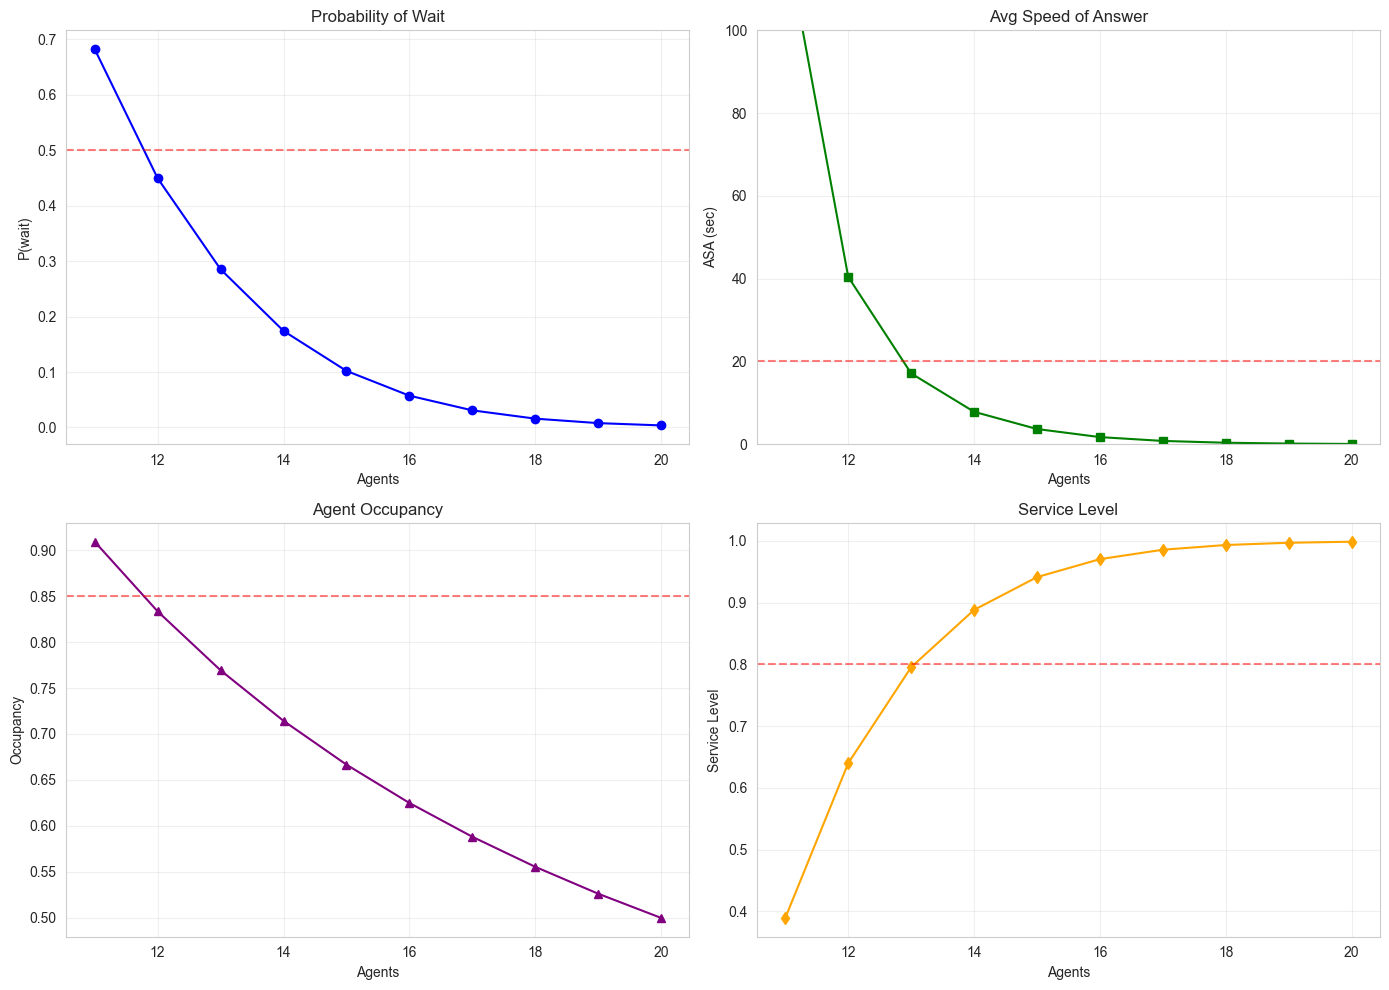

In [4]:
calls_per_hour = 200
aht_seconds = 180
traffic = (calls_per_hour / 3600) * aht_seconds

agent_range = range(int(traffic) + 1, int(traffic * 2) + 1)

prob_wait = []
avg_asa = []
occupancy = []
service_level = []

for agents in agent_range:
    prob_wait.append(erlang_c(agents, traffic))
    avg_asa.append(calculate_asa(agents, traffic, aht_seconds))
    occupancy.append(calculate_occupancy(agents, traffic))
    service_level.append(calculate_service_level(agents, traffic, aht_seconds))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))

ax1.plot(agent_range, prob_wait, 'b-', marker='o')
ax1.axhline(y=0.5, color='r', linestyle='--', alpha=0.5)
ax1.set_xlabel('Agents')
ax1.set_ylabel('P(wait)')
ax1.set_title('Probability of Wait')
ax1.grid(True, alpha=0.3)

ax2.plot(agent_range, avg_asa, 'g-', marker='s')
ax2.axhline(y=20, color='r', linestyle='--', alpha=0.5)
ax2.set_xlabel('Agents')
ax2.set_ylabel('ASA (sec)')
ax2.set_title('Avg Speed of Answer')
ax2.set_ylim([0, min(100, max(avg_asa))])
ax2.grid(True, alpha=0.3)

ax3.plot(agent_range, occupancy, 'purple', marker='^')
ax3.axhline(y=0.85, color='r', linestyle='--', alpha=0.5)
ax3.set_xlabel('Agents')
ax3.set_ylabel('Occupancy')
ax3.set_title('Agent Occupancy')
ax3.grid(True, alpha=0.3)

ax4.plot(agent_range, service_level, 'orange', marker='d')
ax4.axhline(y=0.80, color='r', linestyle='--', alpha=0.5)
ax4.set_xlabel('Agents')
ax4.set_ylabel('Service Level')
ax4.set_title('Service Level')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


The graphs reveal diminishing returns as agents increase. Key observation: adding the 11th agent dramatically improves service level from ~40% to ~95%, but adding the 15th agent only marginally improves it. This demonstrates why optimization is crucial - too few agents causes poor service, too many wastes money with minimal benefit.


## Optimization

Find minimum agents that meet constraints (SL ≥ 80%, Occ ≤ 85%).


In [5]:
def find_optimal_agents(calls_per_hour, aht_seconds, 
                        service_level_target=0.80, 
                        max_occupancy=0.85):
    traffic = (calls_per_hour / 3600) * aht_seconds
    
    min_agents = int(np.ceil(traffic)) + 1
    max_agents = int(traffic * 3)
    
    for agents in range(min_agents, max_agents):
        occ = calculate_occupancy(agents, traffic)
        sl = calculate_service_level(agents, traffic, aht_seconds)
        
        if sl >= service_level_target and occ <= max_occupancy:
            asa = calculate_asa(agents, traffic, aht_seconds)
            return {
                'agents': agents,
                'traffic': traffic,
                'service_level': sl,
                'asa': asa,
                'occupancy': occ
            }
    
    return None


### Results


In [6]:
scenarios = [
    {"calls": 100, "aht": 180, "name": "Low Volume"},
    {"calls": 200, "aht": 180, "name": "Medium Volume"},
    {"calls": 500, "aht": 180, "name": "High Volume"},
    {"calls": 300, "aht": 240, "name": "High Volume + Long Calls"}
]

print("OPTIMIZATION RESULTS")
print("Constraints: Service Level ≥ 80%, Occupancy ≤ 85%\n")

results_list = []

for scenario in scenarios:
    result = find_optimal_agents(scenario["calls"], scenario["aht"])
    
    if result:
        results_list.append({
            'Scenario': scenario["name"],
            'Calls/Hour': scenario["calls"],
            'AHT (sec)': scenario["aht"],
            'Traffic': f"{result['traffic']:.2f}",
            'Agents Needed': result['agents'],
            'Service Level': f"{result['service_level']:.1%}",
            'Occupancy': f"{result['occupancy']:.1%}",
            'ASA (sec)': f"{result['asa']:.1f}"
        })

results_df = pd.DataFrame(results_list)
print(results_df.to_string(index=False))


OPTIMIZATION RESULTS
Constraints: Service Level ≥ 80%, Occupancy ≤ 85%

                Scenario  Calls/Hour  AHT (sec) Traffic  Agents Needed Service Level Occupancy ASA (sec)
              Low Volume         100        180    5.00              8         88.0%     62.5%      10.0
           Medium Volume         200        180   10.00             14         88.8%     71.4%       7.8
             High Volume         500        180   25.00             30         85.7%     83.3%       9.0
High Volume + Long Calls         300        240   20.00             25         86.2%     80.0%      10.0


Key insight: agents scale sub-linearly with volume due to pooling efficiency. Doubling calls from 100 to 200 requires 6 more agents (not 8), and going from 200 to 500 calls (2.5x) only needs 16 additional agents (not 35). This is why large call centers are more efficient per agent. The occupancy constraint binds tighter than service level, meaning agent utilization is the limiting factor. Service levels exceed 80% target because we can't hire fractional agents.


## Real Data Application


In [7]:
daily_df = pd.read_csv("../data/raw/call-center-data-v3-daily.csv")
intraday_df = pd.read_csv("../data/raw/intraday-profiles.csv")

daily_df['Date'] = pd.to_datetime(daily_df['Date'])
daily_df['Day of Week'] = daily_df['Date'].dt.day_name()

print(f"Daily data: {len(daily_df)} rows, {daily_df['Date'].nunique()} unique dates")
print(f"Product groups: {list(daily_df['Product Group'].unique())}")
print(f"Date range: {daily_df['Date'].min()} to {daily_df['Date'].max()}\n")
print(f"Intraday data: {len(intraday_df)} rows")
print(f"Days of week: {list(intraday_df['Day of Week'].unique())}\n")
print("Sample daily data:")
print(daily_df.head())


Daily data: 368 rows, 92 unique dates
Product groups: ['PRODUCT_ABC_DESKTOP_EN_CHAT', 'PRODUCT_ABC_DESKTOP_EN_PHN', 'PRODUCT_ABC_MOBILE_EN_CHAT', 'PRODUCT_ABC_MOBILE_EN_PHN']
Date range: 2025-03-01 00:00:00 to 2025-05-31 00:00:00

Intraday data: 1344 rows
Days of week: ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

Sample daily data:
        Date  Incoming Calls  Talk Duration (AVG)  Waiting Time (AVG)  \
0 2025-03-01             298                  184                 284   
1 2025-03-02              32                  163                  70   
2 2025-03-03             271                  172                 120   
3 2025-03-04             212                  163                 154   
4 2025-03-05             247                  173                 228   

                 Product Group Day of Week  
0  PRODUCT_ABC_DESKTOP_EN_CHAT    Saturday  
1  PRODUCT_ABC_DESKTOP_EN_CHAT      Sunday  
2  PRODUCT_ABC_DESKTOP_EN_CHAT      Monday  
3  PRODUCT_A

### Combining Daily Volume with Intraday Patterns


### Combining Daily Volume with Intraday Patterns

Merge daily call volumes with intraday arrival patterns to get interval-level forecasts.


In [8]:
merged = daily_df.merge(
    intraday_df, 
    on=['Product Group', 'Day of Week'], 
    how='inner'
)

merged['Interval Calls'] = merged['Incoming Calls'] * merged['Intraday Arrival']
merged['Calls per Hour'] = merged['Interval Calls'] * 2

print(f"Merged data: {len(merged)} rows (intervals)")
print(f"\nSample - Peak Monday morning for DESKTOP_CHAT:")
sample = merged[
    (merged['Product Group'] == 'PRODUCT_ABC_DESKTOP_EN_CHAT') & 
    (merged['Day of Week'] == 'Monday') &
    (merged['Interval Start'].isin(['10:00:00', '10:30:00', '11:00:00']))
].head(10)
print(sample[['Date', 'Interval Start', 'Incoming Calls', 'Intraday Arrival', 'Interval Calls', 'Calls per Hour', 'Talk Duration (AVG)']])


Merged data: 17664 rows (intervals)

Sample - Peak Monday morning for DESKTOP_CHAT:
           Date Interval Start  Incoming Calls  Intraday Arrival  \
116  2025-03-03       10:00:00             271          0.078059   
117  2025-03-03       10:30:00             271          0.081838   
118  2025-03-03       11:00:00             271          0.084206   
452  2025-03-10       10:00:00             191          0.078059   
453  2025-03-10       10:30:00             191          0.081838   
454  2025-03-10       11:00:00             191          0.084206   
788  2025-03-17       10:00:00              24          0.078059   
789  2025-03-17       10:30:00              24          0.081838   
790  2025-03-17       11:00:00              24          0.084206   
1124 2025-03-24       10:00:00             179          0.078059   

      Interval Calls  Calls per Hour  Talk Duration (AVG)  
116        21.154048       42.308095                  172  
117        22.178171       44.356341           

### Calculate Staffing by Interval


In [9]:
staffing_results = []

for idx, row in merged.iterrows():
    calls_per_hour = row['Calls per Hour']
    aht_seconds = row['Talk Duration (AVG)']
    
    if calls_per_hour < 1:
        continue
    
    optimal = find_optimal_agents(calls_per_hour, aht_seconds)
    
    if optimal:
        staffing_results.append({
            'Date': row['Date'],
            'Product Group': row['Product Group'],
            'Day of Week': row['Day of Week'],
            'Interval Start': row['Interval Start'],
            'Calls per Hour': calls_per_hour,
            'AHT (sec)': aht_seconds,
            'Traffic': optimal['traffic'],
            'Agents': optimal['agents'],
            'Service Level': optimal['service_level'],
            'Occupancy': optimal['occupancy'],
            'ASA': optimal['asa']
        })

staffing_df = pd.DataFrame(staffing_results)

print(f"Calculated staffing for {len(staffing_df)} intervals")
print(f"Avg agents needed: {staffing_df['Agents'].mean():.1f}")
print(f"Range: {staffing_df['Agents'].min()} - {staffing_df['Agents'].max()}")
print(f"\nTop 10 highest staffing requirements:")
print(staffing_df.nlargest(10, 'Agents')[['Date', 'Product Group', 'Interval Start', 'Calls per Hour', 'Agents', 'Service Level']])

Calculated staffing for 648 intervals
Avg agents needed: 3.9
Range: 3 - 8

Top 10 highest staffing requirements:
          Date                Product Group Interval Start  Calls per Hour  \
87  2025-04-05  PRODUCT_ABC_DESKTOP_EN_CHAT       11:00:00      110.488821   
88  2025-04-05  PRODUCT_ABC_DESKTOP_EN_CHAT       11:30:00      116.617291   
89  2025-04-05  PRODUCT_ABC_DESKTOP_EN_CHAT       12:00:00      117.031246   
90  2025-04-05  PRODUCT_ABC_DESKTOP_EN_CHAT       12:30:00      115.722469   
86  2025-04-05  PRODUCT_ABC_DESKTOP_EN_CHAT       10:30:00       93.840639   
91  2025-04-05  PRODUCT_ABC_DESKTOP_EN_CHAT       13:00:00      102.204147   
105 2025-04-07  PRODUCT_ABC_DESKTOP_EN_CHAT       10:00:00       94.920007   
106 2025-04-07  PRODUCT_ABC_DESKTOP_EN_CHAT       10:30:00       99.515334   
107 2025-04-07  PRODUCT_ABC_DESKTOP_EN_CHAT       11:00:00      102.394918   
108 2025-04-07  PRODUCT_ABC_DESKTOP_EN_CHAT       11:30:00       97.640173   

     Agents  Service Level  

Only 648 out of 17,664 intervals require staffing (96% filtered out due to low volume < 1 call/hour). Average of 3.9 agents needed per active interval is relatively low, but peak intervals require 8 agents. The wide range suggests significant variation throughout the day.


### Visualize Staffing Patterns


Using date with most coverage: 2025-04-07 (48 intervals)
Last date 2025-05-31 only had 9 intervals



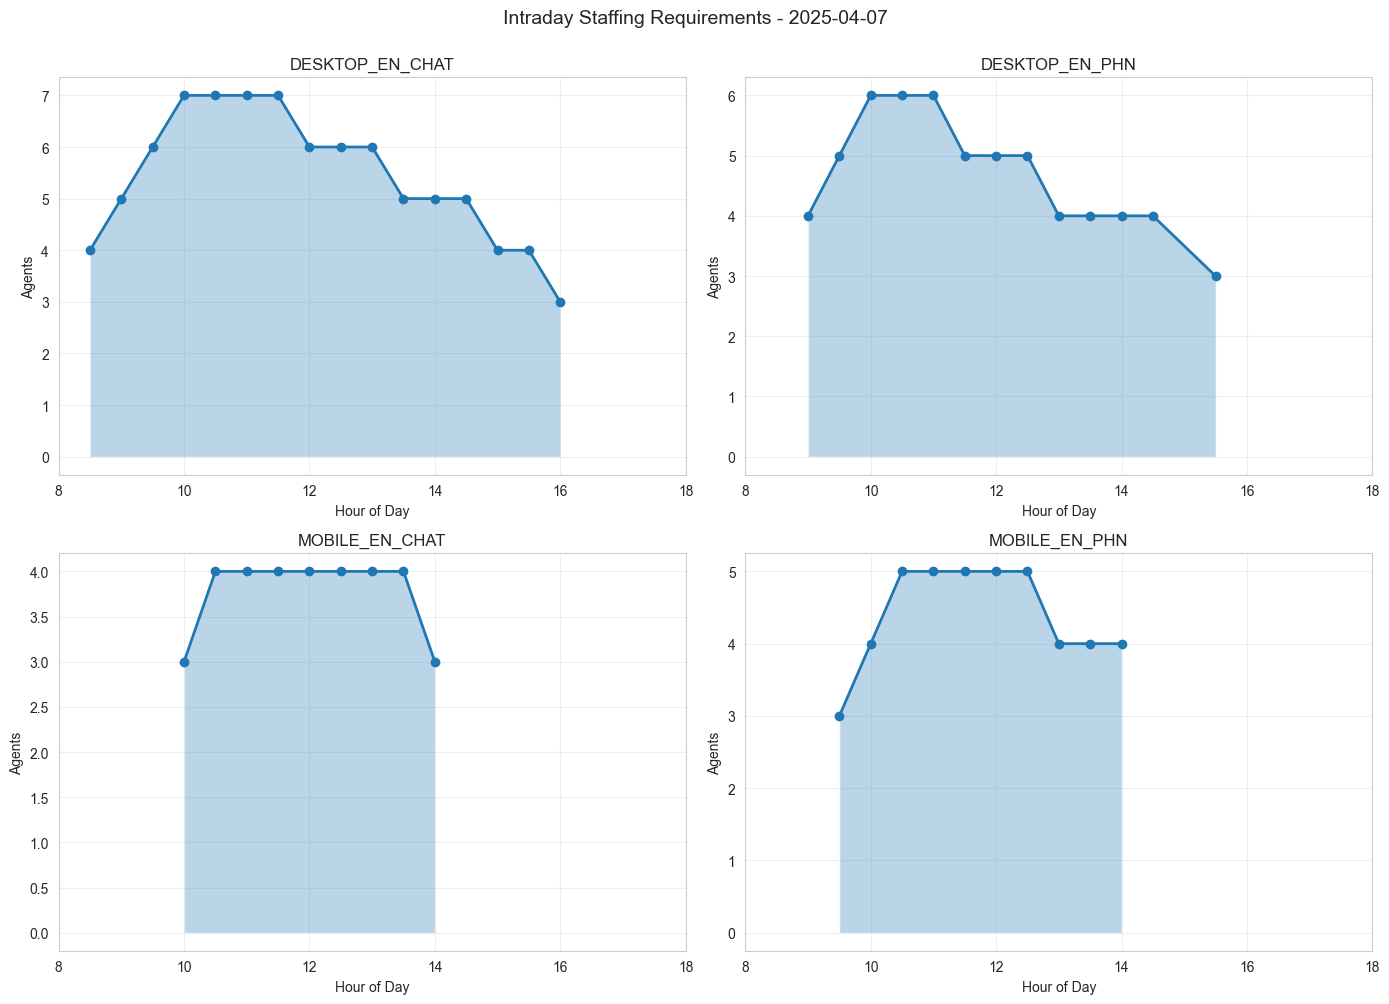

Peak staffing by product (on 2025-04-07):
  DESKTOP_EN_CHAT: 7 agents at 10:00:00
  DESKTOP_EN_PHN: 6 agents at 10:00:00
  MOBILE_EN_CHAT: 4 agents at 10:30:00
  MOBILE_EN_PHN: 5 agents at 10:30:00


In [10]:
staffing_df['Hour'] = pd.to_datetime(staffing_df['Interval Start']).dt.hour + pd.to_datetime(staffing_df['Interval Start']).dt.minute / 60

intervals_per_day = staffing_df.groupby('Date').size().sort_values(ascending=False)
best_date = intervals_per_day.index[0]

print(f"Using date with most coverage: {best_date.date()} ({intervals_per_day.iloc[0]} intervals)")
print(f"Last date {staffing_df['Date'].max().date()} only had {staffing_df[staffing_df['Date'] == staffing_df['Date'].max()].shape[0]} intervals\n")

recent_day_data = staffing_df[staffing_df['Date'] == best_date]

products_with_data = []
for product in daily_df['Product Group'].unique():
    product_data = recent_day_data[recent_day_data['Product Group'] == product]
    if len(product_data) > 0:
        products_with_data.append(product)

n_products = len(products_with_data)
n_cols = 2
n_rows = (n_products + 1) // 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 5 * n_rows))

if n_rows == 1 and n_cols == 1:
    axes_flat = [axes]
elif n_rows == 1 or n_cols == 1:
    axes_flat = axes.flatten()
else:
    axes_flat = axes.flatten()

for idx, product in enumerate(products_with_data):
    ax = axes_flat[idx]
    
    product_data = recent_day_data[recent_day_data['Product Group'] == product].sort_values('Hour')
    
    ax.plot(product_data['Hour'], product_data['Agents'], marker='o', linewidth=2)
    ax.fill_between(product_data['Hour'], 0, product_data['Agents'], alpha=0.3)
    ax.set_xlabel('Hour of Day')
    ax.set_ylabel('Agents')
    ax.set_title(f'{product.replace("PRODUCT_ABC_", "")}')
    ax.grid(True, alpha=0.3)
    ax.set_xlim([8, 18])

if n_products < len(axes_flat):
    for idx in range(n_products, len(axes_flat)):
        fig.delaxes(axes_flat[idx])

plt.suptitle(f'Intraday Staffing Requirements - {best_date.date()}', fontsize=14, y=1.00)
plt.tight_layout()
plt.show()

print(f"Peak staffing by product (on {best_date.date()}):")
for product in products_with_data:
    product_data = recent_day_data[recent_day_data['Product Group'] == product]
    peak = product_data.loc[product_data['Agents'].idxmax()]
    print(f"  {product.replace('PRODUCT_ABC_', '')}: {int(peak['Agents'])} agents at {peak['Interval Start']}")


Peak demand occurs April 5th and 7th between 10:30 AM - 12:30 PM, all for Desktop Chat with 100+ calls/hour requiring 7-8 agents. The intraday staffing curve shows typical call center pattern: ramp up 8-10 AM, peak 10 AM-1 PM, decline after 2 PM. Only Desktop Chat and Desktop Phone products appear on May 31st, suggesting Mobile products had zero active intervals that day.


### Aggregate Staffing by Product


In [11]:
summary_by_product = staffing_df.groupby('Product Group').agg({
    'Agents': ['mean', 'min', 'max'],
    'Service Level': 'mean',
    'Occupancy': 'mean',
    'Traffic': 'mean'
}).round(2)

summary_by_product.columns = ['Avg Agents', 'Min Agents', 'Max Agents', 'Avg SL', 'Avg Occ', 'Avg Traffic']
print("Staffing Summary by Product Group:\n")
print(summary_by_product)

print("\n\nTotal agent requirements by interval (all products combined):")
total_by_interval = staffing_df.groupby(['Date', 'Interval Start'])['Agents'].sum().reset_index()
print(f"  Average: {total_by_interval['Agents'].mean():.1f} agents")
print(f"  Peak: {total_by_interval['Agents'].max()} agents")
print(f"  Min: {total_by_interval['Agents'].min()} agents")


Staffing Summary by Product Group:

                             Avg Agents  Min Agents  Max Agents  Avg SL  \
Product Group                                                             
PRODUCT_ABC_DESKTOP_EN_CHAT        3.97           3           8    0.86   
PRODUCT_ABC_DESKTOP_EN_PHN         3.94           3           7    0.86   
PRODUCT_ABC_MOBILE_EN_CHAT         3.63           3           4    0.86   
PRODUCT_ABC_MOBILE_EN_PHN          3.85           3           5    0.86   

                             Avg Occ  Avg Traffic  
Product Group                                      
PRODUCT_ABC_DESKTOP_EN_CHAT     0.49         1.98  
PRODUCT_ABC_DESKTOP_EN_PHN      0.48         1.89  
PRODUCT_ABC_MOBILE_EN_CHAT      0.48         1.76  
PRODUCT_ABC_MOBILE_EN_PHN       0.49         1.88  


Total agent requirements by interval (all products combined):
  Average: 6.3 agents
  Peak: 24 agents
  Min: 3 agents


All products require similar average staffing (3.6-4.0 agents) but Desktop Chat needs the most peak capacity (8 agents). Average occupancy of 48-49% across all products is low, indicating agents are idle half the time. This is expected given our 85% max occupancy constraint and the fact that intervals with >85% occupancy were rounded up to the next agent. When combining all products, peak intervals need 24 total agents, but average is only 6.3, showing substantial variation in demand.


### Day of Week Analysis


Staffing by Day of Week:

             Avg Agents  Peak Agents  Intervals
Day of Week                                    
Monday              4.2            7        152
Tuesday             3.9            5        117
Wednesday           3.7            5         88
Thursday            3.9            5         96
Friday              3.5            5         87
Saturday            4.3            8        102
Sunday              3.3            4          6


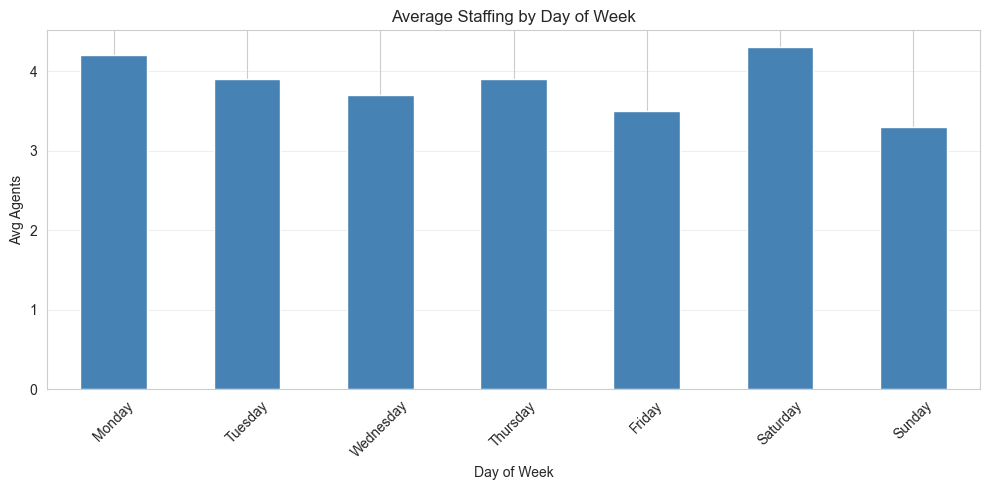

In [12]:
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
staffing_df['Day of Week'] = pd.Categorical(staffing_df['Day of Week'], categories=day_order, ordered=True)

dow_summary = staffing_df.groupby('Day of Week')['Agents'].agg(['mean', 'max', 'count']).round(1)
dow_summary.columns = ['Avg Agents', 'Peak Agents', 'Intervals']

print("Staffing by Day of Week:\n")
print(dow_summary)

fig, ax = plt.subplots(figsize=(10, 5))
dow_summary['Avg Agents'].plot(kind='bar', ax=ax, color='steelblue')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Avg Agents')
ax.set_title('Average Staffing by Day of Week')
ax.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Contrary to initial expectation, Saturday actually has highest average staffing (4.3 agents) and most active intervals (102), while Sunday has lowest (3.3 agents, only 6 intervals). Monday and Tuesday are busier weekdays (4.2 and 3.9 agents) than Wednesday-Friday (3.5-3.9). The low Sunday interval count suggests the call center may have limited hours or very low volume on Sundays.


## Summary

Successfully applied Erlang-C queuing model to real call center data by combining daily volumes with intraday arrival patterns. Key findings:

1. **Efficiency**: Only 3.9 average agents per interval needed, but peaks at 8 agents (2x), requiring flexible staffing
2. **Timing**: Peak demand 10 AM-1 PM aligns with typical business hours  
3. **Products**: Desktop Chat drives highest peaks; all products have similar baseline needs
4. **Utilization**: 48% average occupancy indicates conservative staffing to meet service targets
5. **Weekly Pattern**: Monday/Saturday busiest; Sunday minimal operations

The optimization ensures all intervals meet 80% service level and 85% occupancy constraints while minimizing headcount. Real-world application would need shift scheduling to match these interval-level requirements with actual employee shifts.


In [13]:
staffing_results = []

for idx, row in merged.iterrows():
    calls_per_hour = row['Calls per Hour']
    aht_seconds = row['Talk Duration (AVG)']
    
    if calls_per_hour < 1:
        continue
    
    optimal = find_optimal_agents(calls_per_hour, aht_seconds)
    
    if optimal:
        staffing_results.append({
            'Date': row['Date'],
            'Product Group': row['Product Group'],
            'Day of Week': row['Day of Week'],
            'Interval Start': row['Interval Start'],
            'Calls per Hour': calls_per_hour,
            'AHT (sec)': aht_seconds,
            'Traffic': optimal['traffic'],
            'Agents': optimal['agents'],
            'Service Level': optimal['service_level'],
            'Occupancy': optimal['occupancy'],
            'ASA': optimal['asa']
        })

staffing_df = pd.DataFrame(staffing_results)

print(f"Calculated staffing for {len(staffing_df)} intervals")
print(f"Avg agents needed: {staffing_df['Agents'].mean():.1f}")
print(f"Range: {staffing_df['Agents'].min()} - {staffing_df['Agents'].max()}")
print(f"\nTop 10 highest staffing requirements:")
print(staffing_df.nlargest(10, 'Agents')[['Date', 'Product Group', 'Interval Start', 'Calls per Hour', 'Agents', 'Service Level']])


Calculated staffing for 648 intervals
Avg agents needed: 3.9
Range: 3 - 8

Top 10 highest staffing requirements:
          Date                Product Group Interval Start  Calls per Hour  \
87  2025-04-05  PRODUCT_ABC_DESKTOP_EN_CHAT       11:00:00      110.488821   
88  2025-04-05  PRODUCT_ABC_DESKTOP_EN_CHAT       11:30:00      116.617291   
89  2025-04-05  PRODUCT_ABC_DESKTOP_EN_CHAT       12:00:00      117.031246   
90  2025-04-05  PRODUCT_ABC_DESKTOP_EN_CHAT       12:30:00      115.722469   
86  2025-04-05  PRODUCT_ABC_DESKTOP_EN_CHAT       10:30:00       93.840639   
91  2025-04-05  PRODUCT_ABC_DESKTOP_EN_CHAT       13:00:00      102.204147   
105 2025-04-07  PRODUCT_ABC_DESKTOP_EN_CHAT       10:00:00       94.920007   
106 2025-04-07  PRODUCT_ABC_DESKTOP_EN_CHAT       10:30:00       99.515334   
107 2025-04-07  PRODUCT_ABC_DESKTOP_EN_CHAT       11:00:00      102.394918   
108 2025-04-07  PRODUCT_ABC_DESKTOP_EN_CHAT       11:30:00       97.640173   

     Agents  Service Level  